### Descriptions:

Some initial inclusion/(exclusion) criteria
- have inpatient ID, Hospital encounters only (remove those with NA)
- full code status only (no other code prior to or within 24 hr since admission)
- 18 years and older
- when processing other features, will exclude a few more, mainly those without a complete set of vitals
- add other unprocessed variables from demographics table

**Inputs**: 
- `1_1_cohort` (original init cohort): check years of admission 2015 - 2020
- `encounter` (from SQL) : join with  table to get ESI and inpatient ID information
- `code_status` (from SQL): exclude patients who have any order for EXISTING code status that is not full prior to and within 24hrs after inpatient admission (even if code was cancelled later)
- `demographic`: exclude patients who are < 18 year old

**Outputs**: 
- `1_2_cohort`

### Importing R libraries

In [1]:
library(bigrquery)  # to query STARR-OMOP (stored in BigQuery) using SQL
library(tidyverse)
library(lubridate)

# library(data.table)
# library(Matrix)
# library(caret) # import this before glmnet to avoid rlang version problem
# library(glmnet)
# library(bit64)

# library(slam)
# library(mtools) for one hot coder, not available on Nero or use caret or tidyr
# library(mice)

options(repr.matrix.max.rows=250, repr.matrix.max.cols=30)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.6
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




### Set up BigQuery

https://bigrquery.r-dbi.org/

The bigrquery package makes it easy to work with data stored in Google BigQuery by allowing you to query BigQuery tables and retrieve metadata about your projects, datasets, tables, and jobs. The bigrquery package provides three levels of abstraction on top of BigQuery:

- The low-level API provides thin wrappers over the underlying REST API. All the low-level functions start with `bq_`, and mostly have the form bq_noun_verb(). This level of abstraction is most appropriate if you’re familiar with the REST API and you want do something not supported in the higher-level APIs.

- The `DBI` interface wraps the low-level API and makes working with BigQuery like working with any other database system. This is most convenient layer if you want to execute SQL queries in BigQuery or upload smaller amounts (i.e. <100 MB) of data.

- The `dplyr` interface lets you treat BigQuery tables as if they are in-memory data frames. This is the most convenient layer if you don’t want to write SQL, but instead want dbplyr to write it for you.


In [2]:
# CREDENTIALS depending on LOCATIONS:
# credential <- paste0("/home/", "minh084", "/.config/gcloud/application_default_credentials.json")

# local computer
# credential <- "C:/Users/User/AppData/Roaming/gcloud/application_default_credentials.json"

# Nero onprem
# credential <- "/home/minh084/.config/gcloud/application_default_credentials.json"

# Nero gcp notebook
credential <- "/home/jupyter/.config/gcloud/application_default_credentials.json"

project_id <- "som-nero-phi-jonc101"

Sys.setenv(GOOGLE_APPLICATION_CREDENTIALS = credential)
Sys.setenv(GCLOUD_PROJECT = project_id)
gargle::credentials_app_default()

NULL

In [3]:
library(DBI)
con <- dbConnect(
  bigrquery::bigquery(),
  project = project_id,
  dataset = "shc_core" #, billing = project_id
)
con 
dbListTables(con)

<BigQueryConnection>
  Dataset: som-nero-phi-jonc101.shc_core
  Billing: som-nero-phi-jonc101

[1] "adt"                 "allergy"             "culture_sensitivity"
 [4] "demographic"         "dep_map"             "diagnosis_code"     
 [7] "drg_code"            "encounter"           "family_hx"          
[10] "flowsheet"           "lab_result"          "lda"                
[13] "mapped_meds"         "mar"                 "med_orderset"       
[16] "ndc_code"            "order_med"           "order_proc"         
[19] "order_quest"         "proc_note"           "proc_orderset"      
[22] "procedure_code"      "prov_map"            "social_hx"          
[25] "treatment_team"

### shc_core
* Use init cohort, with admit_time (this is the effective time < event time for admission) from adt table
* No longer checking for admission order from order_proc because these orders don't have the level of care
* Get inpatient id and acuity_level = ESI from encounter table
* Keep patients with FULL CODE status and >=18 year old
* Keep aptients with admit years from 2015 - 2020

In [5]:
cohortdir = "../../OutputTD/1_cohort"

cohort1 <- read.csv(file.path(cohortdir, "1_1_cohort.csv"))
nrow(cohort1)  #55168 vs. 55170
colnames(cohort1)

[1] 55170

[1] "anon_id"              "pat_enc_csn_id_coded" "admit_time_jittered" 
[4] "label"

In [6]:
# Check admit years
cohort1 <- cohort1 %>% mutate(admit_time = ymd_hms(admit_time_jittered), 
                              adm_year = year(admit_time))
unique(cohort1$adm_year)
nrow(cohort1 %>% filter(adm_year==2021))

[1] 2019 2018 2020 2016 2017 2015

[1] 0

In [7]:
# remove patients with admit year 2021
# rename the label as max level of care at 24 hour
# change to date_time, but when saved, it goes back to factor!
cohort1 <- cohort1 %>% mutate(admit_time = ymd_hms(admit_time_jittered), 
                              adm_year = year(admit_time)) %>% 
                        select(-c(admit_time_jittered, adm_year)) 
nrow(cohort1) # 55170 without 2020

[1] 55170

In [8]:
# 1 MRN (patient) can have multiple CSN (visits/encounters)
# but 1 CSN is associated with 1 MRN, for this cohort

nrow(cohort1 %>% distinct(anon_id)) # 36212 (older) vs 36213
nrow(cohort1 %>% distinct(pat_enc_csn_id_coded))
nrow(cohort1 %>% distinct(anon_id, pat_enc_csn_id_coded))
# nrow(cohort1 %>% group_by(anon_id, pat_enc_csn_id_coded, inpatient_data_id_coded) %>% unique()) # unique rows

[1] 36213

[1] 55170

[1] 55170

[1] 36213

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   1.000   1.523   2.000  41.000 

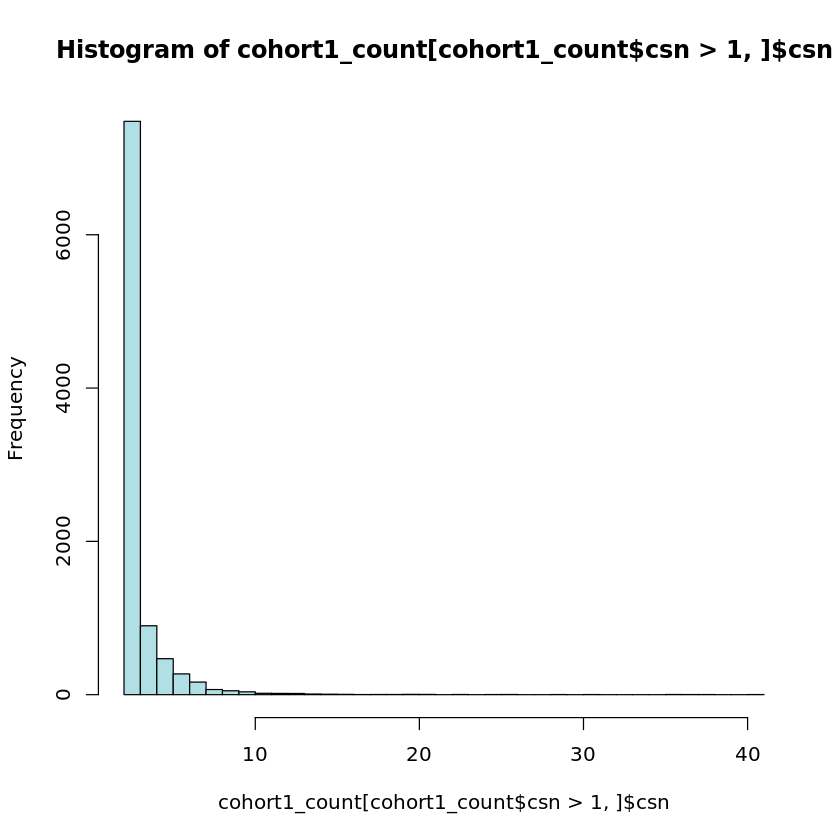

In [9]:
# count how many visits/csn each MRN (anon_id) has
cohort1_count <- cohort1 %>% count(anon_id, sort = TRUE, name = 'csn')
nrow(cohort1_count)
summary(cohort1_count$csn)

# display histogram of freq of patients who have more than 1 visit
hist(cohort1_count[cohort1_count$csn >1, ]$csn, breaks=38, col="powderblue")

In [10]:
head(cohort1_count)

,anon_id,csn
,<chr>,<int>
1,JCe8f38d,41
2,JC29fe299,38
3,JCdc9c9c,37
4,JC2a0d68b,36
5,JCdd32fa,36
6,JCcfe0cb,31


### Encounter, hospital, inpatient IDs

Errors on pat_csn (all NA if SQL is run here in R)

Run `data_BQ/m1_encounter.sql`, output is `encounters.csv`

* This table gives us the inpatient id and ESI level
* Either Hospital encounter or empty (NA) type: only keep Hospital Encounter
* All Visit type are NA, as this might be more applicable to outpatient encounters
* Acuity levels are ESI with some missing (~2200)

==> we can remove enc_type and visit_type
* Hospital Admission time (such as ED arrival) is probably before the admit time (to inpatient) from order proc
* Admit time from init cohort is effective_time_jittered_utc, same as Hospital admission time, all times are UTC

In [36]:
datadir = "../../DataTD"
enc <- read.csv(file.path(datadir, "encounters.csv"))
nrow(enc) # 55170

[1] 55170

In [37]:
enc %>% filter(is.na(inpatient_data_id_coded))

anon_id,pat_enc_csn_id_coded,admit_time_jittered,label,inpatient_data_id_coded,enc_type,visit_type,acuity_level,ACUITY_LEVEL_C,hosp_admsn_time_jittered_utc
<chr>,<dbl>,<chr>,<int>,<dbl>,<chr>,<lgl>,<chr>,<dbl>,<chr>
JC29fea9e,131283506890,2020-03-09 02:48:00+00:00,0,NA,,NA,,NA,
JC2a0a75c,131283296426,2020-01-13 03:38:00+00:00,1,NA,,NA,,NA,
JC2a10dd5,131287909405,2020-03-29 07:10:00+00:00,1,NA,,NA,,NA,
JC2a305eb,131283226027,2020-01-21 03:52:00+00:00,0,NA,,NA,,NA,
JCcbba12,131287849251,2020-03-30 16:39:00+00:00,1,NA,,NA,,NA,
JCd1fa43,131287923845,2020-03-30 19:34:00+00:00,0,NA,,NA,,NA,
JCd2ca79,131288033702,2020-03-31 07:00:00+00:00,0,NA,,NA,,NA,
JCd4996e,131287855587,2020-03-30 08:20:00+00:00,0,NA,,NA,,NA,
JCd58d32,131287959043,2020-03-31 03:24:00+00:00,0,NA,,NA,,NA,


In [38]:
enc %>% gather(var, value) %>% distinct() %>% count(var) %>% arrange(n)

var,n
<chr>,<int>
visit_type,1
enc_type,2
label,2
acuity_level,6
ACUITY_LEVEL_C,6
anon_id,36213
hosp_admsn_time_jittered_utc,54390
admit_time_jittered,54404
inpatient_data_id_coded,55152


In [39]:
summary(enc %>% select(acuity_level, enc_type, visit_type))
summary(enc$ACUITY_LEVEL_C)

# if summary doesn't display (not factor), use table
apply(enc[c("acuity_level", "enc_type", "visit_type")], 2, table)

 acuity_level         enc_type         visit_type    
 Length:55170       Length:55170       Mode:logical  
 Class :character   Class :character   NA's:55170    
 Mode  :character   Mode  :character                 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
   1.00    2.00    3.00    2.64    3.00    5.00    2265 

$acuity_level

                1-Resuscitation      2-Emergent        3-Urgent   4-Semi-Urgent 
           2265             745           18058           33615             468 
   5-Non-Urgent 
             19 

$enc_type

                   Hospital Encounter 
                19              55151 

$visit_type
< table of extent 0 >


In [40]:
# tables
enc %>% group_by(enc_type) %>% count()
enc %>% group_by(acuity_level) %>% count()
enc %>% group_by(ACUITY_LEVEL_C, acuity_level) %>% count()

enc_type,n
<chr>,<int>
,19
Hospital Encounter,55151


acuity_level,n
<chr>,<int>
,2265
1-Resuscitation,745
2-Emergent,18058
3-Urgent,33615
4-Semi-Urgent,468
5-Non-Urgent,19


ACUITY_LEVEL_C,acuity_level,n
<dbl>,<chr>,<int>
1,1-Resuscitation,745
2,2-Emergent,18058
3,3-Urgent,33615
4,4-Semi-Urgent,468
5,5-Non-Urgent,19
NA,,2265


In [41]:
head(enc, 1)
head(cohort1, 1)

,anon_id,pat_enc_csn_id_coded,admit_time_jittered,label,inpatient_data_id_coded,enc_type,visit_type,acuity_level,ACUITY_LEVEL_C,hosp_admsn_time_jittered_utc
,<chr>,<dbl>,<chr>,<int>,<dbl>,<chr>,<lgl>,<chr>,<dbl>,<chr>
1,JC29f8ad2,131274729058,2019-08-31 12:52:00+00:00,0,40679773,Hospital Encounter,NA,3-Urgent,3,2019-08-31 09:59:00+00:00


,anon_id,pat_enc_csn_id_coded,label,admit_time
,<chr>,<dbl>,<int>,<dttm>
1,JC29f8ad2,131274729058,0,2019-08-31 12:52:00


Joining, by = c("anon_id", "pat_enc_csn_id_coded")



[1] 55151

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   2.233   3.483   4.734   5.283 190.433 

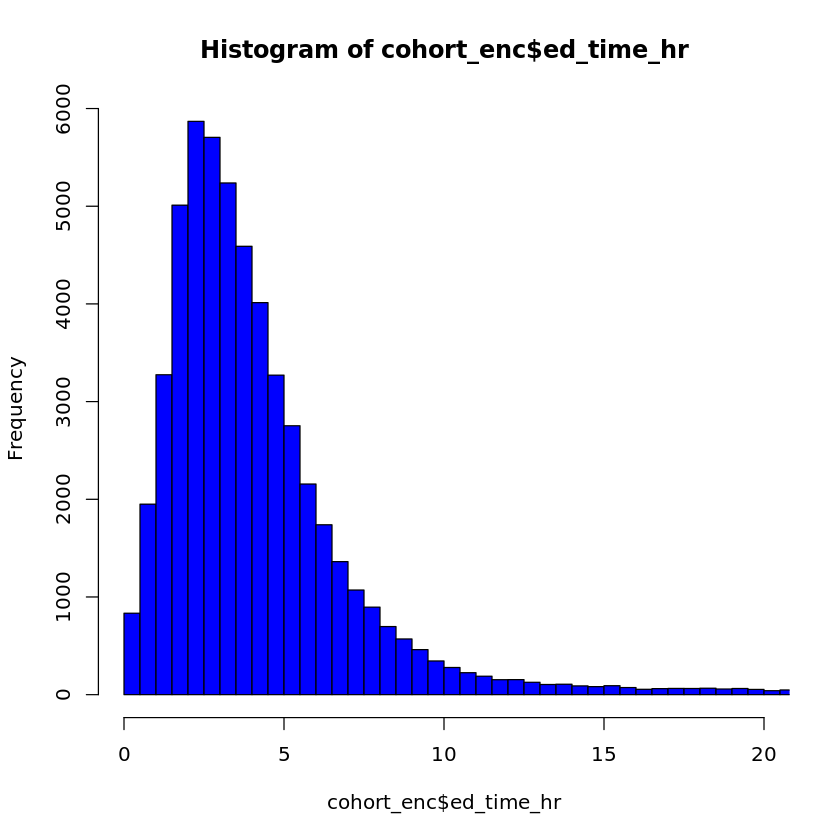

In [42]:
# join the encounter table with cohort table to get the inpatient data id coded
# removed those empty encounter type (18), only Hospital Encounter left
enc <- enc %>% filter(enc_type == "Hospital Encounter") %>%
                select(anon_id, pat_enc_csn_id_coded, inpatient_data_id_coded, 
                       ESI = ACUITY_LEVEL_C, hosp_admsn_time = hosp_admsn_time_jittered_utc) %>% 
                mutate(hosp_admsn_time = ymd_hms(hosp_admsn_time))

cohort_enc <- inner_join(cohort1, enc) %>% 
            mutate(ed_time_hr = as.numeric(difftime(admit_time, hosp_admsn_time, units ="hours")))

nrow(cohort_enc) # 17 vs 19 less: 55151
summary(cohort_enc$ed_time_hr)
hist(cohort_enc$ed_time_hr, xlim=c(0, 20), breaks=300, col="blue")

### Code status

* Process code status: keep patients whose code status is Full prior to admission or within 24 hour after admission. Otherwise interventions might not match with presentations.
* In other words: remove patients whose have a code status not FULL, anytime before admission or within 24 hour after admission 
* Note that in the display_name, some codes are blank but they are converted to something in description --> use description

In [43]:
# codestatus.csv is from querying code status order from order_proc
code <- read.csv(file.path(datadir, "code_status.csv")) 
nrow(code) # 170611
summary(code %>% select(order_status, display_name, description))

# if summary doesn't display (not factor), use table
apply(code[c("order_status", "display_name", "description")], 2, table)

[1] 170611

 order_status       display_name       description       
 Length:170611      Length:170611      Length:170611     
 Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character  

$order_status

         Canceled     Sent 
     207   170221      183 

$display_name

           DNR/C DNR/Comfort Care          DNR/DNE          DNR/DNI 
              58             7081             5511            28037 
       Full code        Full Code     Partial code     Partial Code 
             739           123259                7             5919 

$description

           DNR/C DNR/COMFORT CARE          DNR/DNE          DNR/DNI 
              58             7081             5511            28037 
       FULL CODE     PARTIAL CODE 
          123998             5926 


In [44]:
# tables
code %>% group_by(order_status) %>% count()
code %>% group_by(display_name) %>% count()
code %>% group_by(description) %>% count()

order_status,n
<chr>,<int>
,207
Canceled,170221
Sent,183


display_name,n
<chr>,<int>
DNR/C,58
DNR/Comfort Care,7081
DNR/DNE,5511
DNR/DNI,28037
Full code,739
Full Code,123259
Partial code,7
Partial Code,5919


description,n
<chr>,<int>
DNR/C,58
DNR/COMFORT CARE,7081
DNR/DNE,5511
DNR/DNI,28037
FULL CODE,123998
PARTIAL CODE,5926


In [45]:
head(code, n=1) 

,anon_id,pat_enc_csn_id_coded,admit_time_jittered,label,order_type,order_status,display_name,description,order_time_jittered_utc
,<chr>,<dbl>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>
1,JC29f8ad2,131274729058,2019-08-31 12:52:00+00:00,0,Code Status,Canceled,Full Code,FULL CODE,2019-08-31 17:44:00+00:00


In [46]:
code <- code %>% select(anon_id, pat_enc_csn_id_coded, description, order_time = order_time_jittered_utc) %>% 
                    mutate(order_time = ymd_hms(order_time),
                           description = factor(description)) %>% distinct() 
nrow(code) 
summary(code) 

[1] 82871

   anon_id          pat_enc_csn_id_coded           description   
 Length:82871       Min.   :1.311e+11    DNR/C           :   30  
 Class :character   1st Qu.:1.312e+11    DNR/COMFORT CARE: 3633  
 Mode  :character   Median :1.312e+11    DNR/DNE         : 2779  
                    Mean   :1.312e+11    DNR/DNI         :13975  
                    3rd Qu.:1.313e+11    FULL CODE       :59675  
                    Max.   :1.313e+11    PARTIAL CODE    : 2779  
   order_time                 
 Min.   :2015-01-01 05:27:00  
 1st Qu.:2016-05-31 16:50:00  
 Median :2018-01-14 20:31:00  
 Mean   :2017-10-20 17:09:14  
 3rd Qu.:2019-02-28 23:15:00  
 Max.   :2020-03-31 07:00:00  

In [47]:
# calculate the difference btwn admit time and code status order time
code <- left_join(cohort_enc, code) %>% 
            mutate(code_diff_hr = as.numeric(difftime(order_time, admit_time, units = 'hours')))

nrow(code %>% group_by(anon_id, pat_enc_csn_id_coded) %>% unique()) # 88504
nrow(code %>% select(anon_id, pat_enc_csn_id_coded) %>% group_by(anon_id, pat_enc_csn_id_coded) %>% unique()) # 55151

Joining, by = c("anon_id", "pat_enc_csn_id_coded")



[1] 88504

[1] 55151

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
 -71.27    1.10    2.55   51.19   39.38 5568.32    5658 

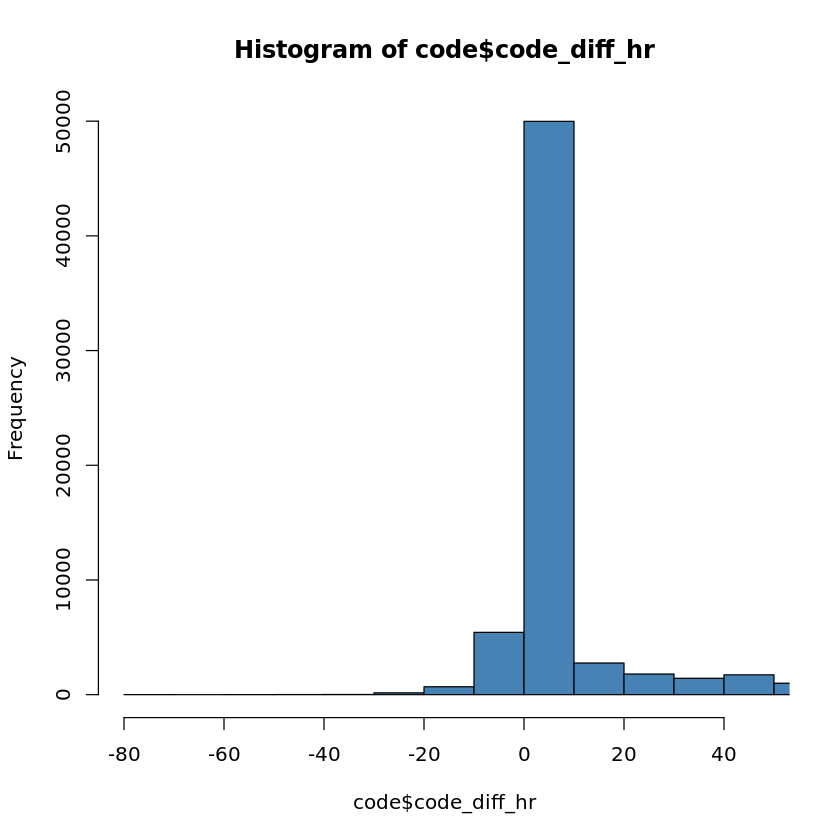

In [48]:
# code order time is prior to or within 24 hours after admission, time diff in hours (code time - admit time)
summary(code$code_diff_hr)
hist(code$code_diff_hr,  xlim=c(-80, 48), breaks=720, col="steelblue")

In [49]:
# number of patients whose code status are either full or na (if exists, consider na = FULL) 
nrow(filter(code, description != "FULL CODE" & !is.na(description))) # to be removed

# cohort of patients whose code status before admission or 24 hour after admission is not FULL CODE
code_notfull <- code %>% 
                filter(code_diff_hr <=24 & description != "FULL CODE" & !is.na(description)) %>% 
                select(anon_id, pat_enc_csn_id_coded, inpatient_data_id_coded, admit_time) %>%
                distinct()

# number of patients whose code status is not full 24
nrow(code_notfull) # 9022 same
nrow(code_notfull %>% select(anon_id, pat_enc_csn_id_coded) %>% distinct()) # 9022

[1] 23187

[1] 9022

[1] 9022

In [50]:
# remove 9022 non-fullcode, non-na code patients from the cohort
cohort_code <- anti_join(cohort_enc, code_notfull) 
nrow(cohort_code) # 46131 vs 46129
nrow(unique(cohort_code %>% select(anon_id, pat_enc_csn_id_coded))) 
nrow(filter(cohort_code, is.na(admit_time)))

Joining, by = c("anon_id", "pat_enc_csn_id_coded", "admit_time", "inpatient_data_id_coded")



[1] 46129

[1] 46129

[1] 0

In [51]:
head(cohort_code, n=1)

,anon_id,pat_enc_csn_id_coded,label,admit_time,inpatient_data_id_coded,ESI,hosp_admsn_time,ed_time_hr
,<chr>,<dbl>,<int>,<dttm>,<dbl>,<dbl>,<dttm>,<dbl>
1,JC29f8ad2,131274729058,0,2019-08-31 12:52:00,40679773,3,2019-08-31 09:59:00,2.883333


### Age from demographic variables
1. Age (only >=18)
2. insurance = Medical/care/caid and n/a insurance --> medis =1 otherwise 0
3. language --> Engl = 1 for English, otherwise 0
4. leave height and weight to be processed with flowsheet age (>=18 only)

In [52]:
demo <- read.csv(file.path(datadir, "demographics.csv")) %>% distinct()
nrow(demo) # 36104
summary(demo)

[1] 36104

   anon_id             gender              race             language        
 Length:36104       Length:36104       Length:36104       Length:36104      
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
                                                                            
                                                                            
                                                                            
                                                                            
 recent_height_cm recent_weight_kg  insurance         recent_date       
 Min.   : 12.7    Min.   :  0.00   Length:36104       Length:36104      
 1st Qu.:160.0    1st Qu.: 60.30   Class :character   Class :character  
 Median :167.6    Median : 72.50   Mode  :character   Mode  :character  
 Mean   :167.5    Mean   : 75.56                                        
 3rd Qu.:175.3    3

In [53]:
head(demo)

,anon_id,gender,race,language,recent_height_cm,recent_weight_kg,insurance,recent_date,dob
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>
1,JC29f8ad2,Female,White,English,165.1,83.46,UNITED HEALTHCARE,2020-03-31,1968-01-23
2,JC29f8ad3,Female,Asian,English,NA,NA,BLUE CROSS,2020-02-24,1984-12-07
3,JC29f8b9c,Male,Unknown,,NA,NA,,2019-01-12,1960-01-21
4,JC29f8beb,Female,White,English,154.9,65.40,CIGNA,2019-12-22,1989-06-19
5,JC29f8bef,Female,Asian,English,156.0,51.70,UNITED HEALTHCARE,2020-03-31,1959-07-05
6,JC29f8c35,Male,White,English,163.6,85.65,,2020-03-13,1947-06-03


In [54]:
# calculate age, only keep patients age >=18, (304 < 18)
cohort_age <- left_join(cohort_code, demo) %>%
                    mutate(dob = ymd(dob), recent_date = ymd(recent_date), gender = factor(gender), 
                           race = factor(race), language = factor(language), insurance = factor(insurance),
                           age = round(as.numeric(difftime(ymd_hms(admit_time), dob, units="days")/365),0)) %>%
                    filter(age >= 18) %>% select(-dob)
nrow(cohort_age) #45796 vs 45794
summary(cohort_age)

Joining, by = "anon_id"



[1] 45794

   anon_id          pat_enc_csn_id_coded     label       
 Length:45794       Min.   :1.311e+11    Min.   :0.0000  
 Class :character   1st Qu.:1.312e+11    1st Qu.:0.0000  
 Mode  :character   Median :1.312e+11    Median :0.0000  
                    Mean   :1.312e+11    Mean   :0.1391  
                    3rd Qu.:1.313e+11    3rd Qu.:0.0000  
                    Max.   :1.313e+11    Max.   :1.0000  
                                                         
   admit_time                  inpatient_data_id_coded      ESI       
 Min.   :2015-01-01 08:24:00   Min.   :13616753        Min.   :1.000  
 1st Qu.:2016-05-21 09:49:30   1st Qu.:19857182        1st Qu.:2.000  
 Median :2017-12-31 23:32:00   Median :27890836        Median :3.000  
 Mean   :2017-10-13 02:11:20   Mean   :28153424        Mean   :2.654  
 3rd Qu.:2019-02-19 07:36:45   3rd Qu.:34378572        3rd Qu.:3.000  
 Max.   :2020-03-31 07:00:00   Max.   :48026130        Max.   :5.000  
                                       

In [55]:
# checking duplicates
nrow(cohort_age %>% select(anon_id) %>% distinct()) # 31513 vs 31511
nrow(cohort_age %>% select(anon_id, pat_enc_csn_id_coded) %>% distinct()) # 45796 vs 45794
cohort_age[duplicated(cohort_age[, c('anon_id','pat_enc_csn_id_coded')]),]

# cohort_demo %>% filter(anon_id == "JCd49287") # pat_enc_csn_id_coded = 131195706986, 
# cohort_demo <- cohort_demo %>% filter (!(anon_id == "JCd49287" & race == "Unknown"))

[1] 31511

[1] 45794

anon_id,pat_enc_csn_id_coded,label,admit_time,inpatient_data_id_coded,ESI,hosp_admsn_time,ed_time_hr,gender,race,language,recent_height_cm,recent_weight_kg,insurance,recent_date,age
<chr>,<dbl>,<int>,<dttm>,<dbl>,<dbl>,<dttm>,<dbl>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<date>,<dbl>


In [56]:
summary(cohort_age %>% select(ESI, gender, race, recent_height_cm, recent_weight_kg, age))
cohort_age %>% gather(var, value) %>% distinct() %>% count(var) %>% arrange(n)
cohort_age %>% summarise_each(funs(n_distinct))
# cohort_demo %>% summarise(across(all_of(.), count))

      ESI           gender                    race       recent_height_cm
 Min.   :1.000   Female:21898   Asian           : 6870   Min.   : 12.95  
 1st Qu.:2.000   Male  :23896   Black           : 3260   1st Qu.:160.02  
 Median :3.000                  Native American :  195   Median :167.64  
 Mean   :2.654                  Other           :10511   Mean   :167.97  
 3rd Qu.:3.000                  Pacific Islander:  930   3rd Qu.:175.26  
 Max.   :5.000                  Unknown         :  424   Max.   :210.82  
 NA's   :1861                   White           :23604   NA's   :1414    
 recent_weight_kg      age       
 Min.   :  0.1    Min.   :18.00  
 1st Qu.: 60.9    1st Qu.:44.00  
 Median : 73.1    Median :60.00  
 Mean   : 76.6    Mean   :58.28  
 3rd Qu.: 88.0    3rd Qu.:73.00  
 Max.   :320.7    Max.   :90.00  
 NA's   :310                     

Warning message:
“attributes are not identical across measure variables;
they will be dropped”


var,n
<chr>,<int>
gender,2
label,2
ESI,6
race,7
language,55
age,73
insurance,134
recent_date,457
recent_height_cm,789


Warning message:
“`summarise_each_()` was deprecated in dplyr 0.7.0.
Please use `across()` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”
Warning message:
“`funs()` was deprecated in dplyr 0.8.0.
Please use a list of either functions or lambdas: 

  # Simple named list: 
  list(mean = mean, median = median)

  # Auto named with `tibble::lst()`: 
  tibble::lst(mean, median)

  # Using lambdas
  list(~ mean(., trim = .2), ~ median(., na.rm = TRUE))
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


anon_id,pat_enc_csn_id_coded,label,admit_time,inpatient_data_id_coded,ESI,hosp_admsn_time,ed_time_hr,gender,race,language,recent_height_cm,recent_weight_kg,insurance,recent_date,age
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
31511,45794,2,45260,45794,6,45278,1922,2,7,55,789,3445,134,457,73


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  18.00   44.00   60.00   58.28   73.00   90.00 

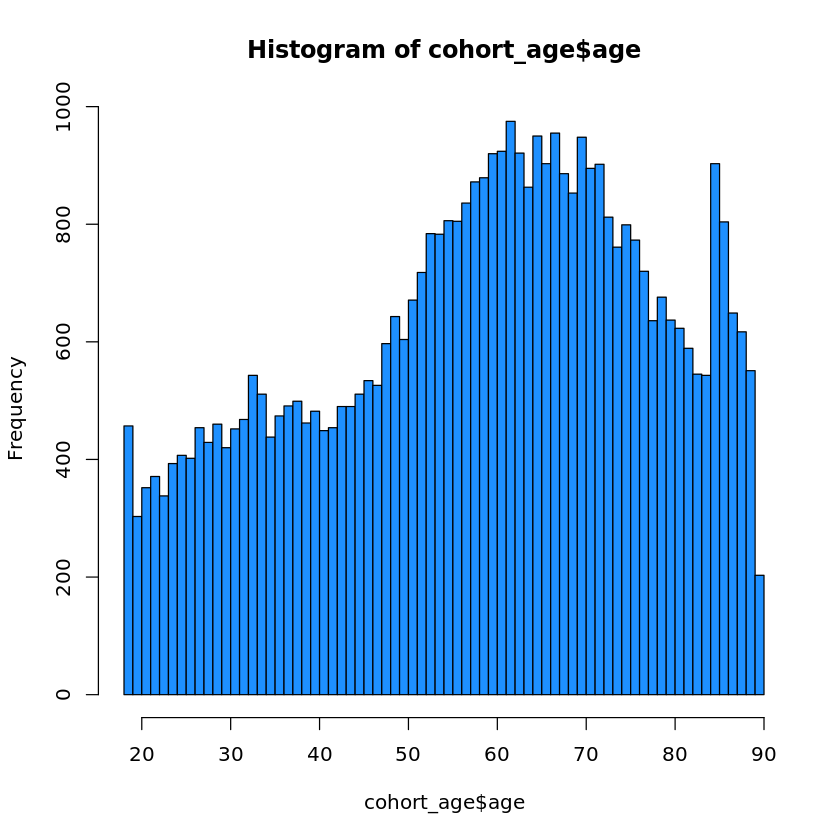

In [57]:
summary(cohort_age$age)
hist(cohort_age$age, breaks=100, col="dodgerblue")

In [58]:
# this is the updated cohort meeting encounter/codestatus/age criteria
write.csv(cohort_age, file = file.path(cohortdir, "1_2_cohort.csv"), row.names=FALSE)

In [59]:
head(cohort_age)

,anon_id,pat_enc_csn_id_coded,label,admit_time,inpatient_data_id_coded,ESI,hosp_admsn_time,ed_time_hr,gender,race,language,recent_height_cm,recent_weight_kg,insurance,recent_date,age
,<chr>,<dbl>,<int>,<dttm>,<dbl>,<dbl>,<dttm>,<dbl>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<date>,<dbl>
1,JC29f8ad2,131274729058,0,2019-08-31 12:52:00,40679773,3,2019-08-31 09:59:00,2.883333,Female,White,English,165.1,83.46,UNITED HEALTHCARE,2020-03-31,52
2,JC29f8ad3,131278291027,0,2019-10-05 23:48:00,42992239,3,2019-10-05 20:07:00,3.683333,Female,Asian,English,NA,NA,BLUE CROSS,2020-02-24,35
3,JC29f8b9c,131266787806,0,2019-05-05 01:07:00,36261582,2,2019-05-05 00:06:00,1.016667,Male,Unknown,,NA,NA,,2019-01-12,59
4,JC29f8beb,131264387263,0,2019-03-15 03:35:00,34626013,3,2019-03-15 00:16:00,3.316667,Female,White,English,154.9,65.40,CIGNA,2019-12-22,30
5,JC29f8beb,131279241689,0,2019-11-27 15:29:00,43527040,3,2019-11-27 13:32:00,1.950000,Female,White,English,154.9,65.40,CIGNA,2019-12-22,30
6,JC29f8bef,131280937356,0,2019-11-30 10:35:00,44544574,3,2019-11-30 06:08:00,4.450000,Female,Asian,English,156.0,51.70,UNITED HEALTHCARE,2020-03-31,60
